# グラフ彩色問題
このチュートリアルでは、量子近似最適化アルゴリズム（QAOA）を用いてグラフ彩色問題を解きます。

まず、使用する主要なライブラリをインストールし、インポートしましょう。

In [1]:
# !pip install qamomile[qiskit, quri_parts]

In [2]:
import jijmodeling as jm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import ommx.v1
import qiskit.primitives as qk_pr
import scipy.optimize as opt

import qamomile.core as qm
from qamomile.core.circuit.drawer import plot_quantum_circuit
from qamomile.qiskit import QiskitTranspiler

## 数理モデルの構築
まず、`JijModeling`を用いてグラフ彩色問題の数理モデルを実装します。

In [3]:
def graph_coloring_problem() -> jm.Problem:
    # 変数を定義する
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    N = jm.Placeholder("N")
    x = jm.BinaryVar("x", shape=(V, N))
    n = jm.Element("i", belong_to=(0, N))
    v = jm.Element("v", belong_to=(0, V))
    e = jm.Element("e", belong_to=E)
    # 問題を設定する
    problem = jm.Problem("Graph Coloring")
    # 各頂点がちょうど1つの色を持つようにする one-hot 制約を設定する
    problem += jm.Constraint("one-color", x[v, :].sum() == 1, forall=v)
    # エッジでつながれた頂点が同じ色になる数を最小化する目的関数を設定する
    problem += jm.sum([n, e], x[e[0], n] * x[e[1], n])
    return problem

problem = graph_coloring_problem()
problem

## インスタンスデータの準備
次に、この問題のインスタンスを作成します。

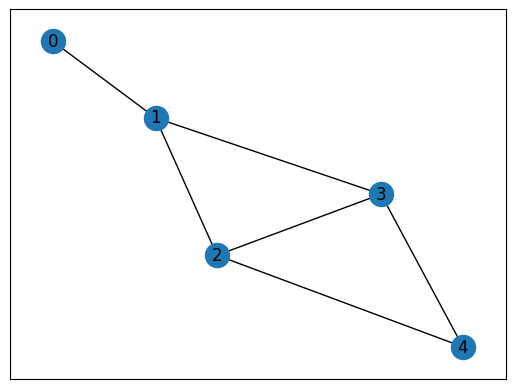

In [4]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (1, 2), (1, 3), (2, 3), (3, 4), (2, 4)])
pos = {0: (-1, 1), 1: (-0.75, 0.75), 2: (-0.6, 0.3), 3: (-0.2, 0.5), 4: (0, 0)}
nx.draw_networkx(G, pos)

In [5]:
inst_E = [list(edge) for edge in G.edges]
color_num = 3
num_nodes = G.number_of_nodes()
instance_data = {"V": num_nodes, "N": color_num, "E": inst_E}
num_qubits = num_nodes * color_num

## コンパイル済みインスタンスの作成
では、QAOAを用いてグラフ彩色問題を解いてみましょう。QAOAを実行するには、数理モデルをイジングハミルトニアンに変換し、量子計算ライブラリを使って変分量子回路とハミルトニアンを作成する必要があります。しかし、`Qamomile`はQAOAをサポートしており、比較的簡単に実行できます。

まず、`JijModeling.Interpreter`を用いて、`JijModeling`の数理モデルとインスタンスデータから`ommx.Instance`を作成します。

In [6]:
interpreter = jm.Interpreter(instance_data)
instance: ommx.v1.Instance = interpreter.eval_problem(problem)

## Qamomileを用いたQAOA回路とハミルトニアンの生成
次に、`QAOAConverter`を作成します。このConverterに制約に対する重みを設定することで、ハミルトニアンを作成できます。

In [7]:
qaoa_converter = qm.qaoa.QAOAConverter(instance)
qaoa_converter.ising_encode(multipliers={"one-color": 5})
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=1)
qaoa_cost = qaoa_converter.get_cost_hamiltonian()

## QAOA 回路の可視化

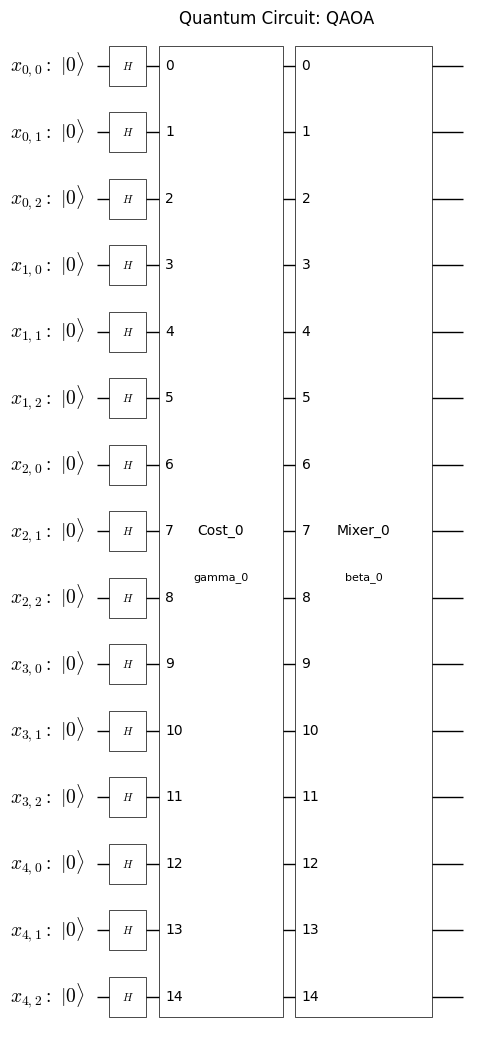

In [8]:
plot_quantum_circuit(qaoa_circuit)

## 取得したQAOA回路とハミルトニアンをQiskit向けに変換

変分量子回路とハミルトニアンの準備が整ったので、実際にQiskitを用いてQAOAを実行してみましょう。Qamomileの回路をQiskitの回路に変換し、シミュレーションを実行します。

In [9]:
qk_transpiler = QiskitTranspiler()
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
qk_cost = qk_transpiler.transpile_hamiltonian(qaoa_cost)

## QAOAの実行

In [10]:
# 変分ステップ
estimator = qk_pr.StatevectorEstimator()

cost_history = []
def estinamate_cost(params):
    job = estimator.run([(qk_circuit, qk_cost, params)])
    job_result = job.result()
    cost = job_result[0].data['evs']
    cost_history.append(cost)
    return cost

result = opt.minimize(estinamate_cost, [0, 0], method="COBYLA", options={"maxiter": 1000})
result

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: 2.8539635187705987
       x: [ 4.545e-01 -3.551e-01]
    nfev: 43
   maxcv: 0.0

## 結果の可視化

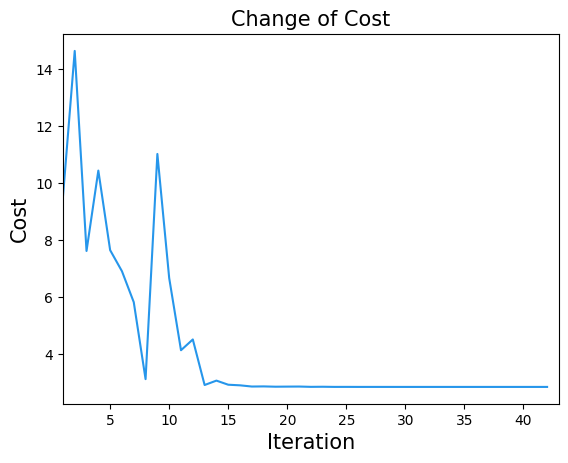

In [11]:
plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

In [12]:
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
plt.show()
job = sampler.run([(qk_circuit, result.x)], shots=10000)
job_result = job.result()

In [13]:
sampleset = qaoa_converter.decode(qk_transpiler, job_result[0].data['meas'])

## 解のプロット

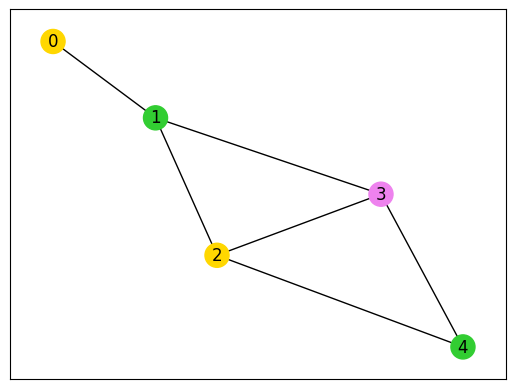

In [14]:
def plot_graph_coloring(graph: nx.Graph, sampleset: ommx.v1.SampleSet):
    # 実行可能解を抽出
    feasibles = [feas for feas in sampleset.feasible.values() if feas]
    if len(feasibles) == 0:
        print("No feasible solution found ...")
    else:
        lowest_sample = sampleset.best_feasible_unrelaxed

        # x = 1のインデックスを取得
        indices = [subscripts for subscripts, value in lowest_sample.extract_decision_variables("x").items() if value == 1]
        # 頂点と色を取得
        # 頂点の色リストを初期化
        node_colors = [-1] * graph.number_of_nodes()
        # 可視化用の色リストを設定
        colorlist = ["gold", "violet", "limegreen", "darkorange"]
        # 頂点の色リストを設定
        for i, j in indices:
            node_colors[i] = colorlist[j]
        # 図を作成
        nx.draw_networkx(graph, pos=pos, node_color=node_colors, with_labels=True)
        plt.show()

# グラフ彩色の結果を可視化
plot_graph_coloring(G, sampleset)